# Text Classification on TR News

## Analyze and Preprocess Dataset

In [1]:
from datasets import load_dataset
import pandas as pd

tr_news = load_dataset("batubayk/TR-News")

classes_to_filter = ['türkiye', 'dünya', 'spor', 'ekonomi', 'sağlık', 'yaşam', 'gündem', 'sanat', 'teknoloji', 'eğitim', 'siyaset']
int_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Dictionary to map class names to integer labels
class_to_int_mapping = {cls: label for cls, label in zip(classes_to_filter, int_labels)}

# Process each split (train, val, test)
for split_name in tr_news.keys():
    
    # Convert the split to a pandas dataframe and select only 'content' and 'topic' columns
    df_split = pd.DataFrame(tr_news[split_name], columns=['content', 'topic'])
    
    # Replace meaningless "\xa0" string with a space in the 'content' column
    df_split['content'] = df_split['content'].replace("\xa0", " ", regex=True)
    
    # Convert 'topic' column to lowercase for case-insensitive matching
    df_split['topic'] = df_split['topic'].str.lower()
    
    # Filter samples based on the 'topic' column
    df_split = df_split[df_split['topic'].isin(classes_to_filter)]

    # Map class names to integer labels
    df_split['topic'] = df_split['topic'].map(class_to_int_mapping)
    
    df_split = df_split.rename(columns={'content': 'text', 'topic': 'label'})

    tr_news[split_name] = df_split

tr_news_train = pd.DataFrame(tr_news['train'])
tr_news_val = pd.DataFrame(tr_news['validation'])
tr_news_test = pd.DataFrame(tr_news['test'])

del tr_news

display(tr_news_train, tr_news_val, tr_news_test)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

,text,label
1,"MHP Genel Başkanı Bahçeli, Manisa'nın Selendi ...",0
4,İspanya'nın Marca Gazetesi'nde yayımlanan deme...,2
5,"Cumhurbaşkanlığı himayesinde, Kültür ve Turizm...",7
6,"Galatasaray Antrenörü Johan Neeskens, bu sezon...",2
7,"Yalvaç Ağır Ceza Mahkemesi, Isparta'nın Yalvaç...",6
...,...,...
277565,"Eskişehir'de, dizi oyuncusu Şeyma Korkmaz'ın k...",0
277566,"Milli Savunma Bakanı Hulusi Akar, Türk Silahlı...",0
277567,Evsahibinin evini görememesi üzerine polise ya...,5
277569,Trabzon'da temizlik çalışması sırasında kanali...,0


,text,label
0,Türk halk müziği ve protest müziğin önemli isi...,0
2,İngiltere devlet televizyonu BBC'nin iş yaşamı...,5
3,Uluslararası Kriz Grubu'nun Irak Kürdistan’ı i...,1
4,"Şampiyonlar Ligi'nde A, B, C ve D gruplarında ...",2
5,TBMM Genel Kurulu'nda Halkların Demokratik Par...,10
...,...,...
14602,Ankara'nın Mamak ilçesinde Mikail Y. yönetimin...,0
14603,Case Western Üniversitesi'nden deneyi gerçekle...,0
14605,Maltepe ilçesi Zümrütevler Mahallesi Nurhan So...,0
14607,ABD Dışişleri Bakanlığı Sözcüsü Heather Nauert...,1


,text,label
0,"Çin Dışişleri Bakanlığı Sözcüsü Hua Çunying, y...",1
1,"İçişleri Bakanı Süleyman Soylu, Van'daki terör...",0
3,Meteoroloji Genel Müdürlüğü'nden yapılan açıkl...,0
4,Filistin’i ziyaret eden Rum Yönetimi Lideri Di...,1
5,Meteoroloji Genel Müdürlüğünden yapılan duyuru...,0
...,...,...
15374,Şırnak Bestler-Dereler bölgesindeki operasyond...,0
15375,ABD'deki en büyük eşcinsel derneği İnsan Hakla...,5
15376,"Mısır güvenlik güçlerinin, Batı Sahra'da Meksi...",1
15377,Geçen yıl Turgutreis Belediyesi'ne yönelik ope...,0



Analysis of TR News Dataset



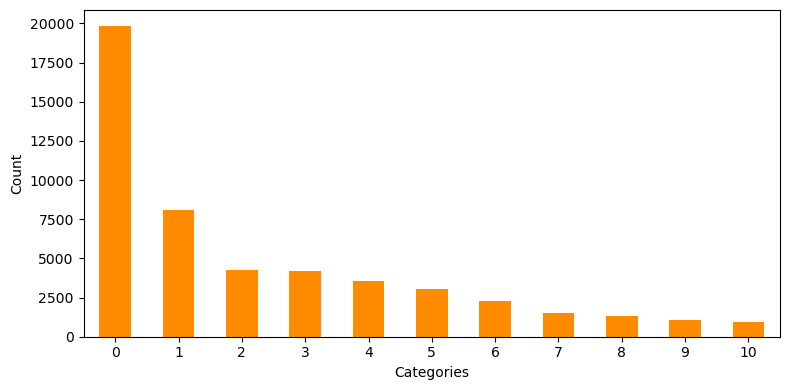


Statistical measures for input text (character-level):



,text
count,50000.00
mean,1875.86
std,2584.51
min,1.00
25%,725.00
50%,1210.50
75%,2198.00
max,248304.00


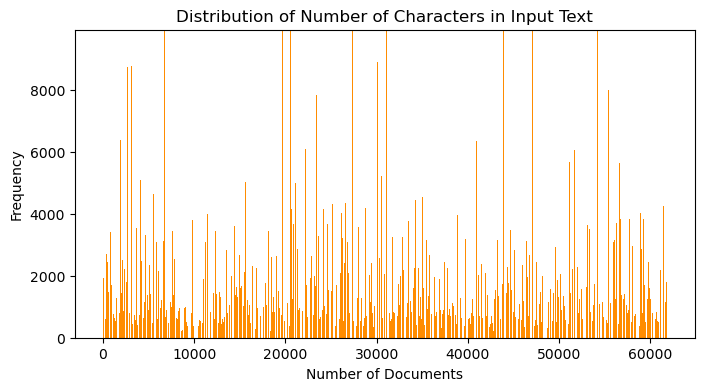

Statistical measures for input text (word-level):



,text
count,50000.00
mean,239.27
std,330.79
min,1.00
25%,92.00
50%,153.00
75%,279.00
max,30735.00


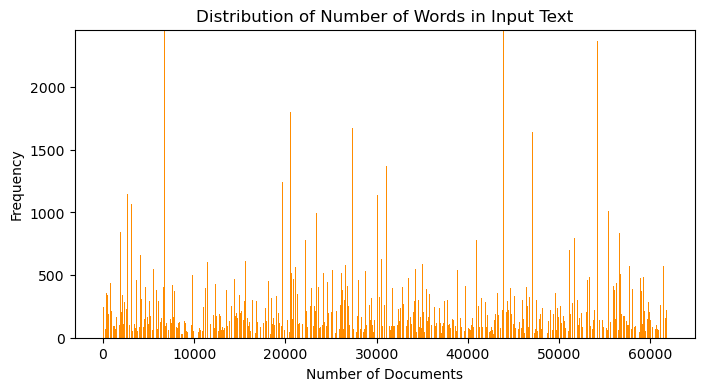

In [4]:
import sys
sys.path.append("../Helper_Functions/")

from general_utils import analyze_dataset 

analyze_dataset(tr_news_train[:50000], 
                (8, 4), (8, 4), (8, 4), 
                0.04, 0.09,
                0.08, 0.09,
                'darkorange', 'TR News')

In [4]:
# tr_news_train.to_csv("../Data/TR_News/tr_news_train.csv", index=False)
# tr_news_val.to_csv("../Data/TR_News/tr_news_val.csv", index=False)
# tr_news_test.to_csv("../Data/TR_News/tr_news_test.csv", index=False)

## Fine Tune

In [1]:
import torch
import pandas as pd

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Preprocess Dataset

In [1]:
# import pandas as pd

# tr_news_train = pd.read_csv("../Data/TR_News/tr_news_train.csv")
# tr_news_val = pd.read_csv("../Data/TR_News/tr_news_val.csv")
# tr_news_test = pd.read_csv("../Data/TR_News/tr_news_test.csv")

# display(tr_news_train, tr_news_val, tr_news_test)

,text,label
0,"MHP Genel Başkanı Bahçeli, Manisa'nın Selendi ...",0
1,İspanya'nın Marca Gazetesi'nde yayımlanan deme...,2
2,"Cumhurbaşkanlığı himayesinde, Kültür ve Turizm...",7
3,"Galatasaray Antrenörü Johan Neeskens, bu sezon...",2
4,"Yalvaç Ağır Ceza Mahkemesi, Isparta'nın Yalvaç...",6
...,...,...
225052,"Eskişehir'de, dizi oyuncusu Şeyma Korkmaz'ın k...",0
225053,"Milli Savunma Bakanı Hulusi Akar, Türk Silahlı...",0
225054,Evsahibinin evini görememesi üzerine polise ya...,5
225055,Trabzon'da temizlik çalışması sırasında kanali...,0


,text,label
0,Türk halk müziği ve protest müziğin önemli isi...,0
1,İngiltere devlet televizyonu BBC'nin iş yaşamı...,5
2,Uluslararası Kriz Grubu'nun Irak Kürdistan’ı i...,1
3,"Şampiyonlar Ligi'nde A, B, C ve D gruplarında ...",2
4,TBMM Genel Kurulu'nda Halkların Demokratik Par...,10
...,...,...
11831,Ankara'nın Mamak ilçesinde Mikail Y. yönetimin...,0
11832,Case Western Üniversitesi'nden deneyi gerçekle...,0
11833,Maltepe ilçesi Zümrütevler Mahallesi Nurhan So...,0
11834,ABD Dışişleri Bakanlığı Sözcüsü Heather Nauert...,1


,text,label
0,"Çin Dışişleri Bakanlığı Sözcüsü Hua Çunying, y...",1
1,"İçişleri Bakanı Süleyman Soylu, Van'daki terör...",0
2,Meteoroloji Genel Müdürlüğü'nden yapılan açıkl...,0
3,Filistin’i ziyaret eden Rum Yönetimi Lideri Di...,1
4,Meteoroloji Genel Müdürlüğünden yapılan duyuru...,0
...,...,...
12505,Şırnak Bestler-Dereler bölgesindeki operasyond...,0
12506,ABD'deki en büyük eşcinsel derneği İnsan Hakla...,5
12507,"Mısır güvenlik güçlerinin, Batı Sahra'da Meksi...",1
12508,Geçen yıl Turgutreis Belediyesi'ne yönelik ope...,0


In [2]:
text_labels = ['türkiye', 'dünya', 'spor', 'ekonomi', 'sağlık', 'yaşam', 'gündem', 'sanat', 'teknoloji', 'eğitim', 'siyaset']
int_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_labels = len(int_labels)

id2label = {label: text_label for label, text_label in zip(int_labels, text_labels)}
label2id = {text_label: label for label, text_label in zip(int_labels, text_labels)}

print(id2label, label2id, sep="\n")

{0: 'türkiye', 1: 'dünya', 2: 'spor', 3: 'ekonomi', 4: 'sağlık', 5: 'yaşam', 6: 'gündem', 7: 'sanat', 8: 'teknoloji', 9: 'eğitim', 10: 'siyaset'}
{'türkiye': 0, 'dünya': 1, 'spor': 2, 'ekonomi': 3, 'sağlık': 4, 'yaşam': 5, 'gündem': 6, 'sanat': 7, 'teknoloji': 8, 'eğitim': 9, 'siyaset': 10}


In [4]:
# from sklearn.utils import resample

# def undersample_data(data, samples_per_class, random_state=42):
    
#     undersampled_data = pd.DataFrame()
    
#     for label in data['label'].unique():
#         class_samples = data[data['label'] == label]
#         undersampled_class = resample(class_samples, replace=False, n_samples=samples_per_class, random_state=random_state)
        
#         undersampled_data = pd.concat([undersampled_data, undersampled_class])

#     return undersampled_data

# samples_per_class_train = 500
# samples_per_class_val = 80
# samples_per_class_test = 80

# tr_news_train = undersample_data(tr_news_train, samples_per_class_train)
# tr_news_val = undersample_data(tr_news_val, samples_per_class_val)
# tr_news_test = undersample_data(tr_news_test, samples_per_class_test)  

# # Shuffle the undersampled sets
# tr_news_train = tr_news_train.sample(frac=1, random_state=42).reset_index(drop=True)
# tr_news_val = tr_news_val.sample(frac=1, random_state=42).reset_index(drop=True)
# tr_news_test = tr_news_test.sample(frac=1, random_state=42).reset_index(drop=True)

# tr_news_train.to_csv("../Data/TR_News/tr_news_train_undersampled.csv", index=False)
# tr_news_val.to_csv("../Data/TR_News/tr_news_val_undersampled.csv", index=False)
# tr_news_test.to_csv("../Data/TR_News/tr_news_test_undersampled.csv", index=False)

In [3]:
tr_news_train = pd.read_csv("../Data/TR_News/tr_news_train_undersampled.csv")
tr_news_val = pd.read_csv("../Data/TR_News/tr_news_val_undersampled.csv")
tr_news_test = pd.read_csv("../Data/TR_News/tr_news_test_undersampled.csv")

X_train = tr_news_train['text'].tolist()
y_train = tr_news_train['label'].tolist()

X_val = tr_news_val['text'].tolist()
y_val = tr_news_val['label'].tolist()

X_test = tr_news_test['text'].tolist()
y_test = tr_news_test['label'].tolist()

print("Train set shape      :", len(X_train), len(y_train))
print("Validation set shape :", len(X_val), len(y_val))
print("Test set shape       :", len(X_test), len(y_test))

Train set shape      : 5500 5500
Validation set shape : 880 880
Test set shape       : 880 880


### Prepare Training

In [4]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def compute_metrics(preds): 
    
    labels = preds.label_ids 
    preds = preds.predictions.argmax(-1) 
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro') 
    acc = accuracy_score(labels, preds) 
    
    return { 
        'Accuracy': acc, 
        'F1': f1, 
        'Precision': precision, 
        'Recall': recall 
    }


def predict(model, tokenizer, text):
    
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    
    return probs, probs.argmax(),model.config.id2label[probs.argmax().item()]

### BERTurk

In [3]:
from transformers import BertTokenizerFast, BertForSequenceClassification

tokenizer_bert = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)
model_bert = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
train_encodings = tokenizer_bert(X_train, truncation=True, padding=True)
val_encodings  = tokenizer_bert(X_val, truncation=True, padding=True)
test_encodings = tokenizer_bert(X_test, truncation=True, padding=True)

from torch.utils.data import Dataset

class MyDataset(Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
        
    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, y_train)
val_dataset = MyDataset(val_encodings, y_val)
test_dataset = MyDataset(test_encodings, y_test)

#### Train

In [8]:
training_args = TrainingArguments(
    output_dir='../Models/berturk_text_classification_fine_tuned_tr_news/', 
    do_train=True,
    do_eval=True,
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',              
    logging_dir='../Output/BERT_Logs_TR_News',            
    logging_steps=100,
    evaluation_strategy="epoch",
    eval_steps=1,
    save_strategy="epoch",
    save_steps=1,
    fp16=True,
    load_best_model_at_end=True
)

trainer_bert = Trainer(
    model=model_bert,                    
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics= compute_metrics
)

In [9]:
trainer_bert.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.794700,0.766880,0.745455,0.738841,0.737842,0.745455
2,0.584600,0.719705,0.780682,0.774428,0.777833,0.780682
3,0.292400,0.766650,0.782955,0.780247,0.780369,0.782955


TrainOutput(global_step=1032, training_loss=0.6734919538793638, metrics={'train_runtime': 7304.1453, 'train_samples_per_second': 2.259, 'train_steps_per_second': 0.141, 'total_flos': 4341683225088000.0, 'train_loss': 0.6734919538793638, 'epoch': 3.0})

#### Evaluate

In [10]:
result = [trainer_bert.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(result, index=["train", "val", "test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.336986,0.897091,0.891995,0.892241,0.897091
val,0.719705,0.780682,0.774428,0.777833,0.780682
test,0.690091,0.780682,0.768171,0.765188,0.780682


In [14]:
text = "Fenerbahçeli futbolcular kısa paslarla hazırlık çalışması yaptılar"
predict(text)[0][0]

tensor([9.7399e-04, 3.3654e-04, 9.9346e-01, 9.5352e-04, 5.4840e-04, 8.9504e-04,
        3.9211e-04, 5.0967e-04, 5.3805e-04, 3.6070e-04, 1.0291e-03],
       device='cuda:0', grad_fn=<SelectBackward0>)

#### Save Model

In [13]:
model_path = "berturk_text_classification_fine_tuned_tr_news"
trainer_bert.save_model(model_path)
tokenizer_bert.save_pretrained(model_path)

('bert_text_classification_fine_tuned_tr_news\\tokenizer_config.json',
 'bert_text_classification_fine_tuned_tr_news\\special_tokens_map.json',
 'bert_text_classification_fine_tuned_tr_news\\vocab.txt',
 'bert_text_classification_fine_tuned_tr_news\\added_tokens.json',
 'bert_text_classification_fine_tuned_tr_news\\tokenizer.json')

### TurkishBERTweet

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_tbt = AutoTokenizer.from_pretrained("VRLLab/TurkishBERTweet", max_length=128)
model_tbt = AutoModelForSequenceClassification.from_pretrained("VRLLab/TurkishBERTweet", num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at VRLLab/TurkishBERTweet and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
train_encodings = tokenizer_tbt(X_train, truncation=True, padding=True, max_length=128)
val_encodings  = tokenizer_tbt(X_val, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer_tbt(X_test, truncation=True, padding=True, max_length=128)

from torch.utils.data import Dataset

class MyDataset(Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
        
    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, y_train)
val_dataset = MyDataset(val_encodings, y_val)
test_dataset = MyDataset(test_encodings, y_test)

#### Train

In [8]:
training_args = TrainingArguments(
    output_dir='../Models/turkishbertweet_text_classification_fine_tuned_tr_news/', 
    do_train=True,
    do_eval=True,
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',              
    logging_dir='../Output/TBT_Logs_TR_News',            
    logging_steps=100,
    evaluation_strategy="epoch",
    eval_steps=1,
    save_strategy="epoch",
    save_steps=1,
    fp16=True,
    load_best_model_at_end=True
)

trainer_tbt = Trainer(
    model=model_tbt,                    
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics= compute_metrics
)

In [9]:
trainer_tbt.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.133400,1.035091,0.677273,0.669312,0.681306,0.677273
2,0.736600,0.996855,0.677273,0.673269,0.686821,0.677273
3,0.353000,0.998325,0.710227,0.707938,0.708987,0.710227


TrainOutput(global_step=1032, training_loss=0.8338423117186672, metrics={'train_runtime': 263.7486, 'train_samples_per_second': 62.56, 'train_steps_per_second': 3.913, 'total_flos': 1085420806272000.0, 'train_loss': 0.8338423117186672, 'epoch': 3.0})

#### Evaluate

In [10]:
result = [trainer_tbt.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(result, index=["train", "val", "test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.402268,0.882727,0.876417,0.879077,0.882727
val,0.996855,0.677273,0.673269,0.686821,0.677273
test,0.925995,0.710227,0.698120,0.704810,0.710227


In [11]:
text = "Fenerbahçeli futbolcular kısa paslarla hazırlık çalışması yaptılar"
predict(model_tbt, tokenizer_tbt, text)[0]

tensor([[1.8906e-03, 1.2073e-03, 9.7862e-01, 1.4149e-03, 9.5739e-04, 3.2960e-03,
         3.6344e-03, 7.7759e-04, 1.3788e-03, 7.4198e-04, 6.0835e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

#### Save Model

In [12]:
model_path = "turkishbertweet_text_classification_fine_tuned_tr_news"

trainer_tbt.save_model(model_path)
tokenizer_tbt.save_pretrained(model_path)

('turkishbertweet_text_classification_fine_tuned_tr_news\\tokenizer_config.json',
 'turkishbertweet_text_classification_fine_tuned_tr_news\\special_tokens_map.json',
 'turkishbertweet_text_classification_fine_tuned_tr_news\\vocab.json',
 'turkishbertweet_text_classification_fine_tuned_tr_news\\merges.txt',
 'turkishbertweet_text_classification_fine_tuned_tr_news\\added_tokens.json',
 'turkishbertweet_text_classification_fine_tuned_tr_news\\tokenizer.json')